In [53]:
!pip install -q plotnine
!pip install -q vaderSentiment
!pip install -q wordfreq


In [67]:
from googleapiclient.discovery import build
from google.colab import drive
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from plotnine import *
from collections import Counter
import wordfreq
import googleapiclient.discovery
import json
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np



# Videos analyzed:
- https://www.youtube.com/watch?v=ceKMnyMYIMo
11958 comments.
# Videos to analyze:
- https://www.youtube.com/watch?v=v9WSjE3tIkg

# TO DO!
- train VaderSentiment with ground truth

# Data Ingestion

In [3]:

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
clean_data = pd.read_csv("/content/drive/MyDrive/ColabNotebooks for NLP and other ML/StrongInternetLanguage/clean_data.csv",
                         header=0, lineterminator='\n', usecols=["COMMENT"])

In [5]:
clean_data.head(25)

,COMMENT
0,oh u are weird
1,for 6 fucking minutes stop trying to be bo bur...
2,we all make mistakes this new generation of ...
3,huh?? what??? girl
4,this whole entire situation is exposing the da...
5,colleen you made kids put their hands down yo...
6,i feel like i’m watching a dramatized episode ...
7,be so fucking serious right now
8,my jaw is on the floor and not in a good way 🫠
9,what 😀 the 😀 actual 😀 fuck 😀


# Unsupervised learning in Sentiment Analysis
Using Vader NLP model.

In [6]:
analyzer = SentimentIntensityAnalyzer()

In [7]:
def sentiment_analyzer_scores(sentence, printable_output:True):
    score = analyzer.polarity_scores(sentence)
    if printable_output:
        print("{:-<40} {}".format(sentence, str(score)))
    return score['compound']

In [8]:
# TESTING THE SENTIMENT_ANALYZER with ambiguous sentences
sentiment_analyzer_scores('yo this kinda a bop😜😍 ', True) #this is probably sarcasm but also ambiguous
sentiment_analyzer_scores('Really nice caitleen, next time pull out a whole piano to sing your song', True)
#unfortunately, the last sarcastic sentence is not evaluated as negative. It's sarcastic because of elements of overly positive complimenting "really nice <name>, next time do x exaggerating it"
sentiment_analyzer_scores('this cannot be real come on', True) #also this is not evaluated in any way, but it is ambiguous.
sentiment_analyzer_scores("This sentence is really hateful and stupid, horrible, disgusting. I am happy and I am so grateful for this sentence instead. Now it is rather something, without further explanation, neutral.",
                          printable_output = True)


yo this kinda a bop😜😍 ------------------ {'neg': 0.0, 'neu': 0.8, 'pos': 0.2, 'compound': 0.4588}
Really nice caitleen, next time pull out a whole piano to sing your song {'neg': 0.0, 'neu': 0.808, 'pos': 0.192, 'compound': 0.4754}
this cannot be real come on------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
This sentence is really hateful and stupid, horrible, disgusting. I am happy and I am so grateful for this sentence instead. Now it is rather something, without further explanation, neutral. {'neg': 0.304, 'neu': 0.476, 'pos': 0.22, 'compound': -0.7087}


-0.7087

In [9]:
clean_data['COMPOUND'] = clean_data['COMMENT'].apply(sentiment_analyzer_scores, printable_output = False)

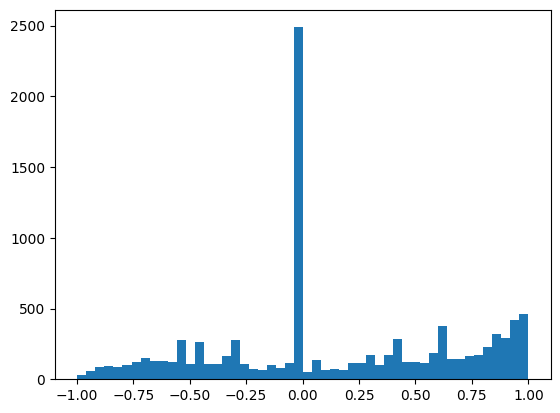

In [11]:
plt.hist(clean_data['COMPOUND'], bins = 50)
plt.show()

In [83]:
clean_data['LABEL'] = clean_data['COMPOUND'].apply(lambda x: 'neg' if x <= -0.05 else ('pos' if x >= 0.05 else 'neu'))
clean_data['LENGTH'] = clean_data['COMMENT'].apply(lambda text: len([el if el != ' ' and el !=  'br' else None for el in text.split(' ')]))

In [88]:
clean_data = clean_data.sort_values(by='COMPOUND', ascending=True)

In [89]:
most_common = [i[0] for i in Counter(clean_data['COMMENT'].values).most_common(150)]

In [90]:
most_common

['❤',
 'yikes',
 '❤❤❤',
 'girl what',
 'oh',
 'what the fuck',
 'i love you colleen',
 'hi',
 'girl',
 'what',
 'girl what is this',
 'i love you',
 'girl…',
 'yikes ',
 'bruh',
 'what the fuck is this',
 'no way',
 'girl ',
 'what is this',
 'what the hell is this',
 'girl what the fuck',
 'oh no',
 'omg',
 '❤️',
 'chat is this real',
 'this has to be a joke',
 'lol',
 'lmao',
 'love you colleen ❤',
 '❤❤',
 'this is unhinged',
 'this cannot be real',
 'wow',
 'love you colleen!',
 '❤❤❤❤',
 '❤❤❤❤❤',
 'what the hell',
 'girl what the fuck is this',
 'i missed you',
 'bye ',
 'girl   ',
 'oof',
 'um',
 'what?',
 'first',
 'you cannot be serious',
 'what a joke',
 'love you colleen',
 'we love you colleen',
 'love you colleen ❤️',
 'i love you ❤',
 'oh hell no',
 'girl what the hell',
 'pathetic',
 'what the actual fuck',
 'what is wrong with you',
 'weirdo',
 'there’s no way this is real',
 'ain’t no way',
 'is this real',
 'shut up',
 '❤️❤️❤️',
 'lmaoooo',
 'girl bffr',
 ' 3',
 'queen',

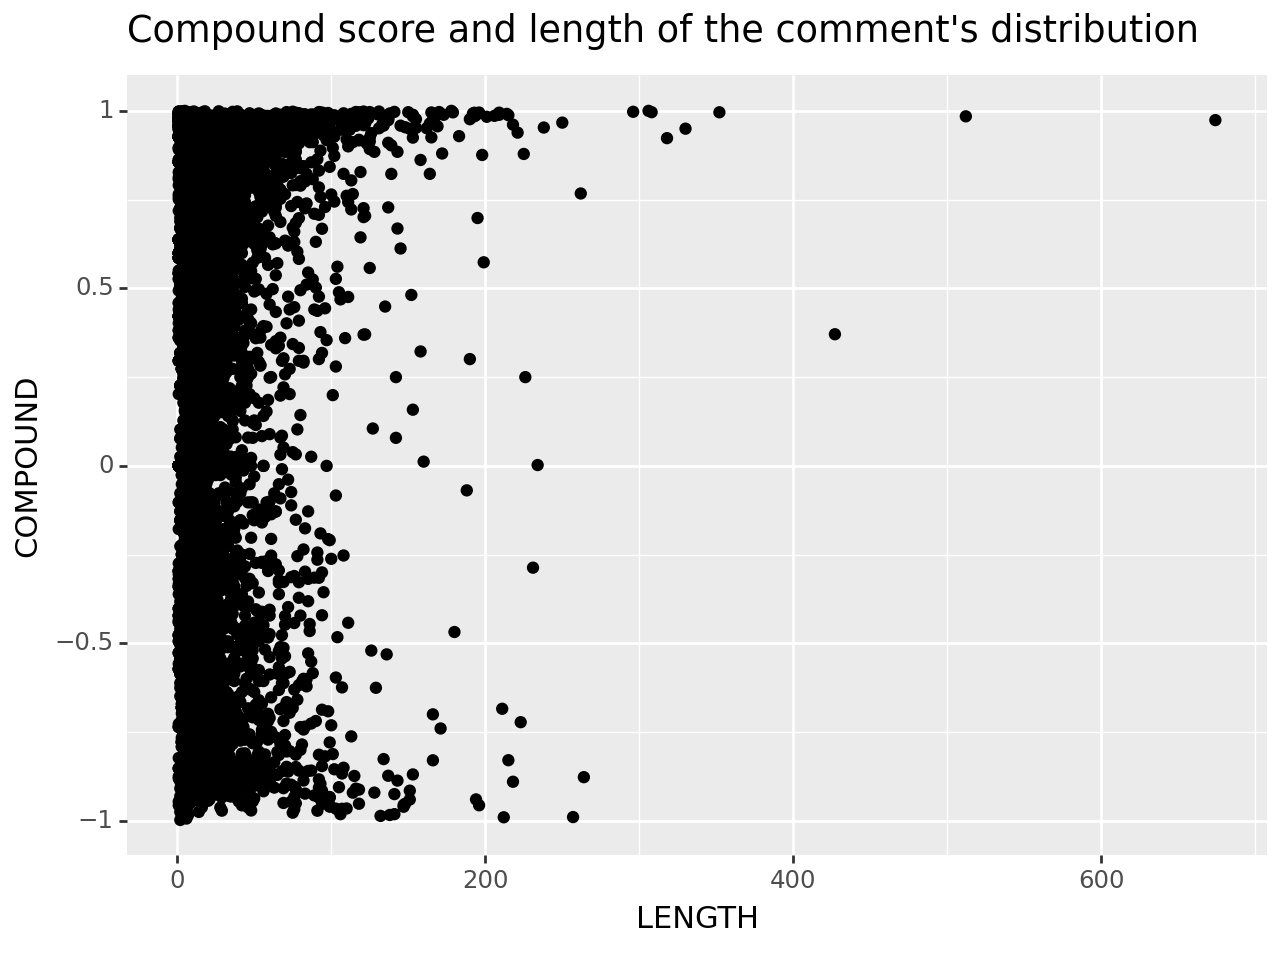

In [18]:
p = ggplot(data=clean_data, mapping=aes(y='COMPOUND', x='LENGTH')) + \
    geom_point() + \
    labs(title='Compound score and length of the comment\'s distribution', y='COMPOUND', x='LENGTH')
print(p)


In [19]:
r = np.corrcoef(clean_data['COMPOUND'], clean_data['LENGTH'])
print("The correlation coefficient between length and compound score is:" + str(r[0, 1])[:6]) #Thankfully, there is little correlation between length and compound.
# Below you can see there are few comments that make it above 200 words, but they are not spam and are actually very useful for this analysis.
# there are a few spam comments but they don't do much harm to the research,
# question, as the spam was meant to be offensive or very positive as a reaction to the video and not to change topic.


The correlation coefficient between length and compound score is:0.1635


In [20]:
clean_data

,COMMENT,COMPOUND,LABEL,LENGTH
0,oh u are weird,-0.1779,neg,5
1,for 6 fucking minutes stop trying to be bo bur...,-0.3566,neg,10
2,we all make mistakes this new generation of ...,0.8999,pos,111
3,huh?? what??? girl,0.0000,neu,4
4,this whole entire situation is exposing the da...,-0.8777,neg,25
...,...,...,...,...
10042,oh no…,0.0000,neu,3
10043,girl are you being for real rn???,0.0000,neu,10
10044,what s the difference between colleen and gabb...,0.0000,neu,12
10045,girl,0.0000,neu,1


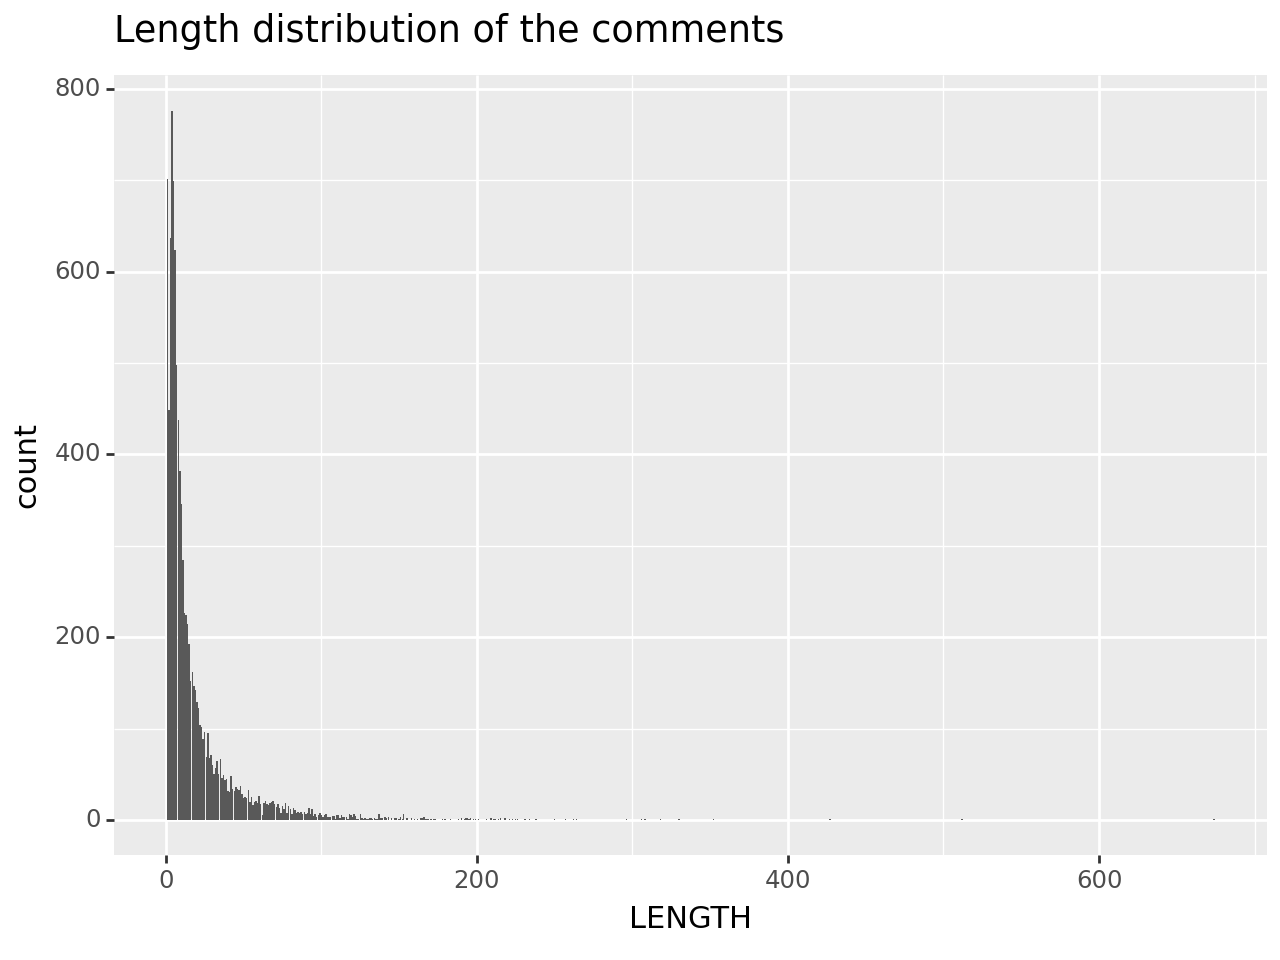

 [[1.         0.16359391]
 [0.16359391 1.        ]]


In [21]:
p = (ggplot(clean_data, aes('LENGTH')) +
     geom_bar() +
     labs(title='Length distribution of the comments')
)
print(p, r)

# Ground truth
To evaluate, I will make ground truth using my own perception of comments. I am aware that my perception might differ from what the authors of the comments have meant, but my perception is by far still better than this model as I could tell.

Sarcasm went often unnoticed - even when it was pretty offensive, take this actual example from the data:
- "she really thought she ate omg 😂🤡🤡".

It's sarcastic and slang to say that "she [the youtuber] thought she did a good job, oh my god [laughing emoji, clown emoji twice]". Using the clown emoji and using sarcasm went unnoticed, and it had $0.44$ on a scale from $-1$ (negative) to $1$ (positive) as compound score made from negative, neutral and positive scores attributed.

Personally, I believe this model is biased towards negative comments and tends to pick them up as positive even when to humans they could be seen as subtly negative or sarcastic.

# Sampling original comments for human annotation
In order to annotate comments, I need to have the original version with all the punctuation and especially if they used caps lock (which has a different tone of voice), as those elements actually help me better understand the feeling of the original commentor.


In [22]:
with open("/content/drive/MyDrive/ColabNotebooks for NLP and other ML/StrongInternetLanguage/raw_comments.json", "r") as f:
    to_sample = json.load(f)
    to_sample = pd.DataFrame(to_sample.values())

In [23]:
sample = to_sample.sample(n=1000, replace=False, random_state=25) #25 is the seed
#sample.to_csv('/content/drive/MyDrive/ColabNotebooks for NLP and other ML/StrongInternetLanguage/sample_for_groundtruth.csv', index=True)

In [24]:
sample.head()

,0
6811,GIRL REALLY?????
278,Idk what she did. But i forgive her.
3005,there’s literally no way this is real
394,I vote this the BEST APOLOGY VIDEO of all time...
7021,new worst YouTube apology vid dropped. Laura l...


# Evaluation

In [25]:
test = pd.read_csv("/content/drive/MyDrive/ColabNotebooks for NLP and other ML/StrongInternetLanguage/annotations.csv",
                         header=0, lineterminator='\n', usecols=["Semantic evaluation", 'User ID'], index_col=['User ID'])

In [26]:
test['Comments'] = sample[0]
print(len(test))
test.head()

1000


,Semantic evaluation,Comments
User ID,,
6811,-1.0,GIRL REALLY?????
278,1.0,Idk what she did. But i forgive her.
3005,-1.0,there’s literally no way this is real
394,-1.0,I vote this the BEST APOLOGY VIDEO of all time...
7021,-1.0,new worst YouTube apology vid dropped. Laura l...


To test:
- each prediction using python will be coded as Positive (if $pos > 0.2$), negative (if $neg > 0.2$) and everything else as neutral
- then, the accuracy metric will be computed based on the 3x3 confusion matrix resulting from this.

In [34]:
# modifying a bit the model so that it fits the definition for the loss function
def discrete_sentiment_analyzer(sentence, printable_output:True):
    score = analyzer.polarity_scores(sentence)
    if printable_output:
        print("{:-<40} {}".format(sentence, str(score)))
    if score['compound'] >= 0.05:
        return 1
    elif score['compound'] <= -0.05 :
        return -1
    return 0  #if score['compound'] is between -0.05 and 0.05, neutral it is!
discrete_sentiment_analyzer("Idk what she did. But i forgive her.", printable_output=True)
discrete_sentiment_analyzer("BZZzzzz", printable_output=True)
discrete_sentiment_analyzer("Hateful", printable_output=True)

Idk what she did. But i forgive her.---- {'neg': 0.122, 'neu': 0.609, 'pos': 0.269, 'compound': 0.3506}
BZZzzzz--------------------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Hateful--------------------------------- {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.4939}


-1

In [35]:
sample['Semantic evaluation'] = sample[0].apply(discrete_sentiment_analyzer, printable_output = False)

In [36]:
sample.head(10)

,0,Semantic evaluation
6811,GIRL REALLY?????,0
278,Idk what she did. But i forgive her.,1
3005,there’s literally no way this is real,-1
394,I vote this the BEST APOLOGY VIDEO of all time...,1
7021,new worst YouTube apology vid dropped. Laura l...,-1
5081,I like your video Colleen,1
5708,you’re delusional,0
1006,Are you kidding me?!!,1
5171,WHAT IS HAPPENING BRO…? 😨,-1
2137,What happened to crying in front of a camera,-1


In [30]:
# Accuracy is the number of diagonal observations on the confusion matrix divided by N. Example:
'''
        predicted Positive Negative Neutral
ground_t
Positive             0       1       1
Negative             1       1       0
Neutral              1       0       1

'''
#it should be when all labels from one dataframe exactly match correspondant from the other
(1+1)/6

0.3333333333333333

In [37]:
mask = sample['Semantic evaluation'].astype(int) == test['Semantic evaluation'].astype(int)

In [38]:
print(sum(mask.astype(int))/1000)
#that's a low accuracy, but it could've been worse (since there are three labels, if the assignment was really randomic this could've been around 0.333)

0.542


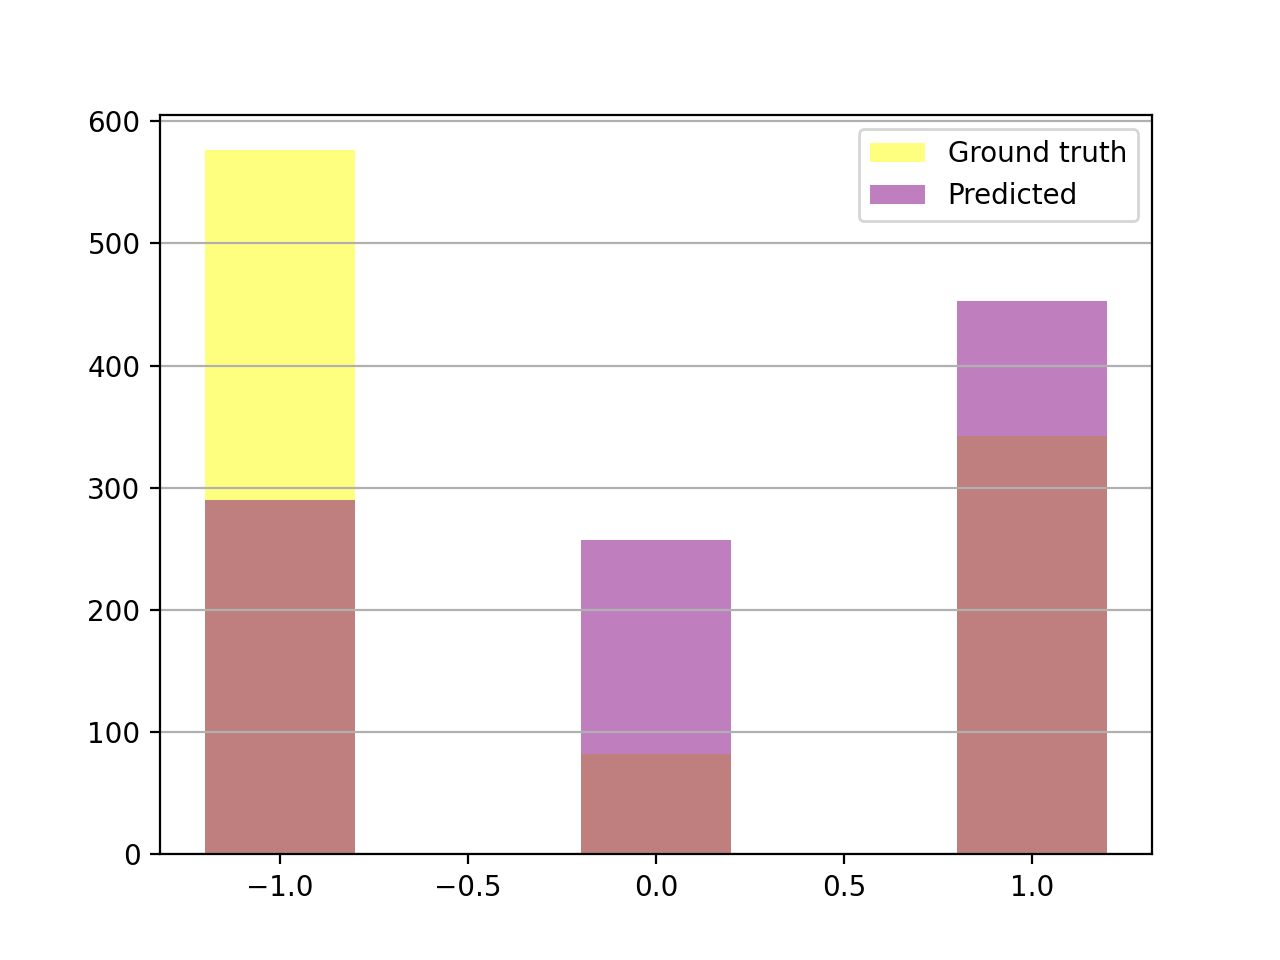

In [92]:
bin_edges = [-1.2, -0.8, -0.2, 0.2, 0.8, 1.2]
plt.hist(test['Semantic evaluation'],bins=bin_edges, alpha=0.5, label="Ground truth", color="yellow")
plt.hist(sample['Semantic evaluation'], bins=bin_edges, alpha=0.5, label="Predicted", color="purple")
plt.grid(axis = 'y')
plt.legend()
plt.show()

The ready-to-use python model works well with predicting positive comments, but it does fail with the sarcasm and slang used offensively that is immensely present in the data. I shall also note that I tend to see many comments as less neutral and attribute them to polarize them, likely because I perceive them as sarcastic or sympathetic with Coleen (as in actually heartwarming) but they are expressed in a long and formal way, which might be computed as negative by VADER.  

# Topic Identification
To do so, Gensim's library for Python will be used.[Topic Identification](https://www.analyticsvidhya.com/blog/2022/02/topic-identification-with-gensim-library-using-python/) 